# Imports

In [1]:
import logging
import os

import pandas as pd

import core.config.config_ as cconconf
import core.finance as cofinanc
import dataflow.core as dtfcore
import dataflow.system.source_nodes as dtfsysonod
import helpers.hdbg as hdbg
import helpers.hprint as hprint
import helpers.hsql as hsql
import im_v2.ccxt.data.client as icdcl
import im_v2.im_lib_tasks as imvimlita

import im_v2.talos.data.client.talos_clients as imvtdctacl

/app/dataflow/core/dag.py:15: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


INFO: > cmd='/venv/lib/python3.8/site-packages/ipykernel_launcher.py -f /home/.local/share/jupyter/runtime/kernel-5a4dea30-870b-4687-aa91-561b43f2236d.json'


In [2]:
hdbg.init_logger(verbosity=logging.INFO)

_LOG = logging.getLogger(__name__)

hprint.config_notebook()

  File "/usr/lib/python3.8/runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.8/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/venv/lib/python3.8/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/venv/lib/python3.8/site-packages/traitlets/config/application.py", line 846, in launch_instance
    app.start()
  File "/venv/lib/python3.8/site-packages/ipykernel/kernelapp.py", line 677, in start
    self.io_loop.start()
  File "/venv/lib/python3.8/site-packages/tornado/platform/asyncio.py", line 199, in start
    self.asyncio_loop.run_forever()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 570, in run_forever
    self._run_once()
  File "/usr/lib/python3.8/asyncio/base_events.py", line 1859, in _run_once
    handle._run()
  File "/usr/lib/python3.8/asyncio/events.py", line 81, in _run
    self._context.run(self._callback, *self._args)
  File "/ve

# Config

In [3]:
def get_cmtask1704_config_ccxt() -> cconconf.Config:
    """
    Get config, that specifies params for getting raw data.
    """
    config = cconconf.Config()
    # Load parameters.
    config.add_subconfig("load")
    env_file = imvimlita.get_db_env_path("dev")
    connection_params = hsql.get_connection_info_from_env_file(env_file)
    config["load"]["connection"] = hsql.get_connection(*connection_params)
    config["load"]["aws_profile"] = "ck"
    config["load"]["data_dir_hist"] = os.path.join(
        "s3://cryptokaizen-data", "historical"
    )
    config["load"]["data_snapshot"] = "latest"
    config["load"]["partition_mode"] = "by_year_month"
    # Data parameters.
    config.add_subconfig("data")
    config["data"]["vendor"] = "CCXT"
    # Data range for real-time data.
    config["data"]["start_date_rt"] = pd.Timestamp("2022-04-01", tz="UTC")
    config["data"]["end_date_rt"] = pd.Timestamp("2022-04-15", tz="UTC")
    # Data range for historical data.
    config["data"]["start_date_hist"] = pd.Timestamp("2022-01-01", tz="UTC")
    config["data"]["end_date_hist"] = pd.Timestamp("2022-01-15", tz="UTC")
    # Transformation parameters.
    config.add_subconfig("transform")
    config["transform"]["resampling_rule"] = "5T"
    config["transform"]["rets_type"] = "pct_change"
    return config

In [4]:
config = get_cmtask1704_config_ccxt()
print(config)

load:
  connection: <connection object; dsn: 'user=postgres password=xxx dbname=im_data_db host=dev-im-db.cpox8ul7pzan.eu-north-1.rds.amazonaws.com port=5432', closed: 0>
  aws_profile: ck
  data_dir_hist: s3://cryptokaizen-data/historical
  data_snapshot: latest
  partition_mode: by_year_month
data:
  vendor: CCXT
  start_date_rt: 2022-04-01 00:00:00+00:00
  end_date_rt: 2022-04-15 00:00:00+00:00
  start_date_hist: 2022-01-01 00:00:00+00:00
  end_date_hist: 2022-01-15 00:00:00+00:00
transform:
  resampling_rule: 5T
  rets_type: pct_change


# Functions

In [5]:
def calculate_vwap_twap(df: pd.DataFrame, resampling_rule: str) -> pd.DataFrame:
    """
    Resample the data and calculate VWAP, TWAP using DataFlow methods.

    :param df: Raw data
    :param resampling_rule: Desired resampling frequency
    :return: Resampled multiindex DataFrame with computed metrics
    """
    # Configure the node to do the TWAP / VWAP resampling.
    node_resampling_config = {
        "in_col_groups": [
            ("close",),
            ("volume",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "rule": resampling_rule,
            "resampling_groups": [
                ({"close": "close"}, "last", {}),
                (
                    {
                        "close": "twap",
                    },
                    "mean",
                    {},
                ),
                (
                    {
                        "volume": "volume",
                    },
                    "sum",
                    {"min_count": 1},
                ),
            ],
            "vwap_groups": [
                ("close", "volume", "vwap"),
            ],
        },
        "reindex_like_input": False,
        "join_output_with_input": False,
    }
    # Put the data in the DataFlow format (which is multi-index).
    converted_data = dtfsysonod._convert_to_multiindex(df, "full_symbol")
    # Create the node.
    nid = "resample"
    node = dtfcore.GroupedColDfToDfTransformer(
        nid,
        transformer_func=cofinanc.resample_bars,
        **node_resampling_config,
    )
    # Compute the node on the data.
    vwap_twap = node.fit(converted_data)
    # Save the result.
    vwap_twap_df = vwap_twap["df_out"]
    return vwap_twap_df

In [6]:
def calculate_returns(df: pd.DataFrame, rets_type: str) -> pd.DataFrame:
    """
    Compute returns on the resampled data DataFlow-style.

    :param df: Resampled multiindex DataFrame
    :param rets_type: i.e., "log_rets" or "pct_change"
    :return: The same DataFrame but with attached columns with returns
    """
    # Configure the node to calculate the returns.
    node_returns_config = {
        "in_col_groups": [
            ("close",),
            ("vwap",),
            ("twap",),
        ],
        "out_col_group": (),
        "transformer_kwargs": {
            "mode": rets_type,
        },
        "col_mapping": {
            "close": "close.ret_0",
            "vwap": "vwap.ret_0",
            "twap": "twap.ret_0",
        },
    }
    # Create the node that computes ret_0.
    nid = "ret0"
    node = dtfcore.GroupedColDfToDfTransformer(
        nid,
        transformer_func=cofinanc.compute_ret_0,
        **node_returns_config,
    )
    # Compute the node on the data.
    rets = node.fit(df)
    # Save the result.
    rets_df = rets["df_out"]
    return rets_df

# Load the data

## CCXT

### Real-time

In [7]:
# Specify params.
vendor = config["data"]["vendor"]
resample_1min = True
connection = config["load"]["connection"]
# Initiate the client.
ccxt_rt_client = icdcl.CcxtCddDbClient(vendor, resample_1min, connection)

#### Universe

In [8]:
# Specify the universe.
rt_universe_ccxt = ccxt_rt_client.get_universe()
len(rt_universe_ccxt)

38

In [9]:
# Choose cc for analysis.
full_symbols = rt_universe_ccxt[0:2]
full_symbols

['binance::ADA_USDT', 'binance::AVAX_USDT']

#### Data Loader

In [10]:
# Specify time period.
start_date = config["data"]["start_date_rt"]
end_date = config["data"]["end_date_rt"]

# Load the data.
data_rt_ccxt = ccxt_rt_client.read_data(full_symbols, start_date, end_date)
display(data_rt_ccxt.shape)
display(data_rt_ccxt.head(3))

/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(
/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(40322, 6)

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2022-04-01 00:00:00+00:00,binance::ADA_USDT,1.141,1.144,1.141,1.141,258996.40
2022-04-01 00:00:00+00:00,binance::AVAX_USDT,97.430,97.750,97.300,97.380,8115.09
2022-04-01 00:01:00+00:00,binance::ADA_USDT,1.140,1.142,1.137,1.138,96911.50


### Historical

In [11]:
# Specify params.
resample_1min = True
root_dir = config["load"]["data_dir_hist"]
partition_mode = config["load"]["partition_mode"]
data_snapshot = config["load"]["data_snapshot"]
aws_profile = config["load"]["aws_profile"]

# Initiate the client.
historical_client_ccxt = icdcl.CcxtHistoricalPqByTileClient(
    resample_1min,
    root_dir,
    partition_mode,
    data_snapshot=data_snapshot,
    aws_profile=aws_profile,
)

#### Universe

In [12]:
# Specify the universe.
historical_universe = historical_client_ccxt.get_universe()
len(historical_universe)

38

In [13]:
# Choose cc for analysis.
full_symbols = historical_universe[0:2]
full_symbols

['binance::ADA_USDT', 'binance::AVAX_USDT']

#### Data Loader

In [14]:
# Specify time period.
start_date = config["data"]["start_date_hist"]
end_date = config["data"]["end_date_hist"]

# Load the data.
data_hist_ccxt = historical_client_ccxt.read_data(full_symbols, start_date, end_date)
display(data_hist_ccxt.shape)
display(data_hist_ccxt.head(3))

(40322, 6)

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2022-01-01 00:00:00+00:00,binance::ADA_USDT,1.308,1.310,1.307,1.310,98266.80
2022-01-01 00:00:00+00:00,binance::AVAX_USDT,109.430,109.880,109.420,109.720,1560.17
2022-01-01 00:01:00+00:00,binance::ADA_USDT,1.310,1.314,1.308,1.312,132189.40


## Talos

### Real-time

In [15]:
# Specify params.
resample_1min = True
db_connection = config["load"]["connection"]
table_name = "talos_ohlcv"

talos_rt_client = imvtdctacl.RealTimeSqlTalosClient(
resample_1min,
db_connection,
table_name)

/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


#### Universe

In [16]:
# Specify the universe.
rt_universe_talos = sorted(talos_rt_client.get_universe())
len(rt_universe_talos)

/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


16

In [17]:
# Choose cc for analysis.
full_symbols = rt_universe_talos[0:2]
full_symbols

['binance::ADA_USDT', 'binance::AVAX_USDT']

#### Data Loader

In [18]:
# Specify the period.
start_date = config["data"]["start_date_rt"]
end_date = config["data"]["end_date_rt"]

# Load the data.
data_rt_talos = talos_rt_client.read_data(
full_symbols,
start_date,
end_date)
display(data_rt_talos.shape)
display(data_rt_talos.head(3))

/venv/lib/python3.8/site-packages/pandas/io/sql.py:761: UserWarning: pandas only support SQLAlchemy connectable(engine/connection) ordatabase string URI or sqlite3 DBAPI2 connectionother DBAPI2 objects are not tested, please consider using SQLAlchemy
  warnings.warn(


(40322, 6)

,open,high,low,close,volume,full_symbol
timestamp,,,,,,
2022-04-01 00:00:00+00:00,1.141,1.144,1.141,1.141,258996.40,binance::ADA_USDT
2022-04-01 00:00:00+00:00,97.430,97.750,97.300,97.380,8115.09,binance::AVAX_USDT
2022-04-01 00:01:00+00:00,1.140,1.142,1.137,1.138,96911.50,binance::ADA_USDT


### Historical

In [19]:
# Specify params.
resample_1min = True
root_dir = config["load"]["data_dir_hist"]
partition_mode = config["load"]["partition_mode"]
data_snapshot = config["load"]["data_snapshot"]
aws_profile = config["load"]["aws_profile"]

talos_hist_client = imvtdctacl.TalosHistoricalPqByTileClient(
resample_1min,
root_dir,
partition_mode,
data_snapshot=data_snapshot,
aws_profile=aws_profile)

#### Universe

In [20]:
# Specify the universe.
hist_universe_talos = talos_hist_client.get_universe()
len(hist_universe_talos)

4

In [21]:
# Choose cc for analysis.
full_symbols_hist_talos = hist_universe_talos[0:2]
full_symbols_hist_talos

['binance::ADA_USDT', 'binance::BTC_USDT']

#### Data Loader

In [22]:
# Specify the period.
start_date = config["data"]["start_date_hist"]
end_date = config["data"]["end_date_hist"]

# Load the data.
data_hist_talos = talos_hist_client.read_data(
    full_symbols_hist_talos,
    start_date,
    end_date
)
# Hardcoded solution to convert OHLCV to the 'float' type for the further use.
for cols in data_hist_talos.columns[1:]:
    data_hist_talos[cols] = data_hist_talos[cols].astype(float)
# Show the data.
display(data_hist_talos.shape)
display(data_hist_talos.head(3))

(40322, 6)

,full_symbol,open,high,low,close,volume
timestamp,,,,,,
2022-01-01 00:00:00+00:00,binance::ADA_USDT,1.308,1.310,1.307,1.310,98266.80000
2022-01-01 00:00:00+00:00,binance::BTC_USDT,46216.930,46271.080,46208.370,46250.000,40.57574
2022-01-01 00:01:00+00:00,binance::ADA_USDT,1.310,1.314,1.308,1.312,132189.40000


# Calculate VWAP, TWAP and returns in `Dataflow` style

## CCXT

In [23]:
# VWAP, TWAP transformation.
resampling_rule = config["transform"]["resampling_rule"]
vwap_twap_df = calculate_vwap_twap(data_hist_ccxt, resampling_rule)

# Returns calculation.
rets_type = config["transform"]["rets_type"]
vwap_twap_rets_df = calculate_returns(vwap_twap_df, rets_type)

In [24]:
# Show the snippet.
vwap_twap_rets_df.head(3)

close.ret_0                           twap.ret_0                           vwap.ret_0                                close                                 twap                               volume                                 vwap                   
                          binance::ADA_USDT binance::AVAX_USDT binance::ADA_USDT binance::AVAX_USDT binance::ADA_USDT binance::AVAX_USDT binance::ADA_USDT binance::AVAX_USDT binance::ADA_USDT binance::AVAX_USDT binance::ADA_USDT binance::AVAX_USDT binance::ADA_USDT binance::AVAX_USDT
timestamp                                                                                                                                                                                                                                                                                   
2022-01-01 00:00:00+00:00               NaN                NaN               NaN                NaN               NaN                NaN             1.310             109.72            1.3100            109.720           98266.8            1560.17          1.310000         109.720000
2022-01-01 00:05:00+00:00          0.006107           0.005013          0.003969           0.002643          0.004587           0.002715             1.318             110.27            1.3152            110.010         1186381.0            8421.98          1.316009         110.017835
2022-01-01 00:10:00+00:00         -0.000759          -0.000453          0.001825           0.002145          0.001425           0.002578             1.317             110.22            1.3176            110.246          243249.6            6639.44          1.317884         110.301428

,close.ret_0,twap.ret_0,vwap.ret_0
close.ret_0,1.000000,0.702344,0.769028
twap.ret_0,0.702344,1.000000,0.957020
vwap.ret_0,0.769028,0.957020,1.000000


<AxesSubplot:xlabel='timestamp'>

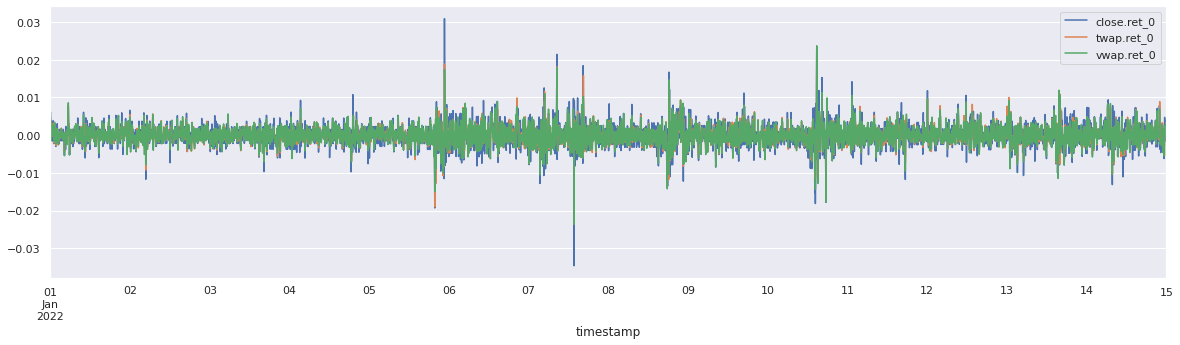

In [25]:
# Stats and vizualisation to check the outcomes.
ada_ex = vwap_twap_rets_df.swaplevel(axis=1)
ada_ex = ada_ex["binance::ADA_USDT"][["close.ret_0", "twap.ret_0", "vwap.ret_0"]]
display(ada_ex.corr())
ada_ex.plot()

## Talos

In [26]:
# VWAP, TWAP transformation.
resampling_rule = config["transform"]["resampling_rule"]
vwap_twap_df_talos = calculate_vwap_twap(data_hist_talos, resampling_rule)

# Returns calculation.
rets_type = config["transform"]["rets_type"]
vwap_twap_rets_df_talos = calculate_returns(vwap_twap_df_talos, rets_type)

In [27]:
# Show the snippet.
vwap_twap_rets_df_talos.head(3)

close.ret_0                          twap.ret_0                          vwap.ret_0                               close                                twap                              volume                                vwap                  
                          binance::ADA_USDT binance::BTC_USDT binance::ADA_USDT binance::BTC_USDT binance::ADA_USDT binance::BTC_USDT binance::ADA_USDT binance::BTC_USDT binance::ADA_USDT binance::BTC_USDT binance::ADA_USDT binance::BTC_USDT binance::ADA_USDT binance::BTC_USDT
timestamp                                                                                                                                                                                                                                                                            
2022-01-01 00:00:00+00:00               NaN               NaN               NaN               NaN               NaN               NaN             1.310          46250.00            1.3100         46250.000           98266.8          40.57574          1.310000      46250.000000
2022-01-01 00:05:00+00:00          0.006107          0.004022          0.003969          0.002248          0.004587          0.002316             1.318          46436.03            1.3152         46353.988         1186381.0         180.96666          1.316009      46357.134946
2022-01-01 00:10:00+00:00         -0.000759         -0.001211          0.001825          0.001374          0.001425          0.001688             1.317          46379.80            1.3176         46417.698          243249.6          98.22629          1.317884      46435.389625

,close.ret_0,twap.ret_0,vwap.ret_0
close.ret_0,1.000000,0.702120,0.768858
twap.ret_0,0.702120,1.000000,0.956964
vwap.ret_0,0.768858,0.956964,1.000000


<AxesSubplot:xlabel='timestamp'>

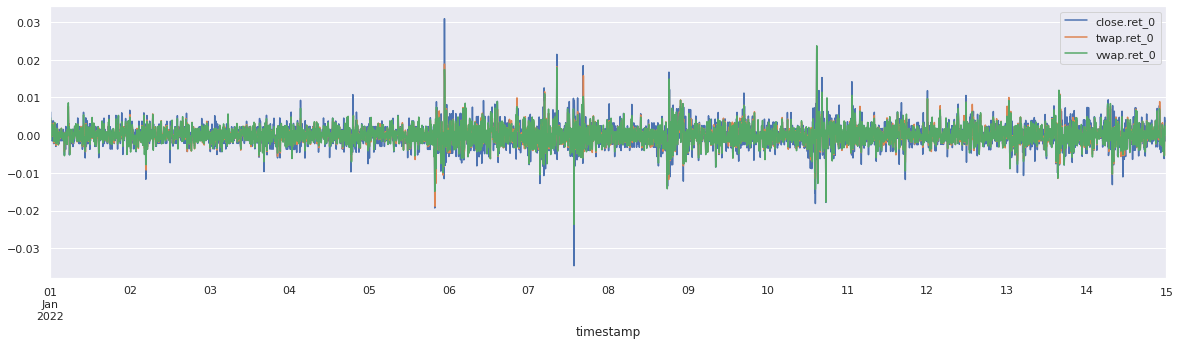

In [28]:
# Stats and vizualisation to check the outcomes.
ada_ex = vwap_twap_rets_df_talos.swaplevel(axis=1)
ada_ex = ada_ex["binance::ADA_USDT"][["close.ret_0", "twap.ret_0", "vwap.ret_0"]]
display(ada_ex.corr())
ada_ex.plot()